In [ ]:
entrainer un bot par crypto avec une boucle
entrainer sur target differente (risikadj)
faire les preds j+7
faire les prediction entre janvier et aujourdhui

In [2]:
import numpy as np
import sys
from tsfracdiff import FractionalDifferentiator
sys.path.append('..')
from lib.download import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [10]:
exp_name = '/ETHUSDT_ohlc_8_top2_samelr'
path = 'results'+exp_name
preds = np.load(path+'/pred.npy')
true = np.load(path+'/true.npy')

In [11]:
#'/prix_8_top2_type2' pr backtest

<Axes: xlabel='timestamp'>

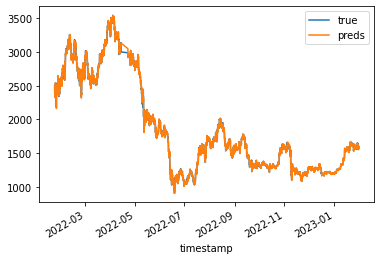

In [13]:
from sklearn.preprocessing import StandardScaler

data = get_data_features('ETHUSDT').dropna()
data = data.loc[:, data.nunique() != 1]

#close j+1 est la target
target_aligned = data[['close']].copy().shift(-1).iloc[:-1]
data_aligned = data.iloc[:-1,:]
data_aligned["target"] = target_aligned

target_scaler = StandardScaler()
target_train = pd.DataFrame(data_aligned.iloc[:int(len(data_aligned) * 0.7),-1].copy())
target_scaler = target_scaler.fit(target_train)

rescaled_data = pd.DataFrame(target_scaler.inverse_transform(true.T[0][0].reshape(-1,1)), columns=['true'])
rescaled_data['preds'] = pd.DataFrame(target_scaler.inverse_transform(preds.T[0][0].reshape(-1,1)))
rescaled_data.index = target_aligned.iloc[-len(preds):].index
rescaled_data['true_return'] = rescaled_data['true'].pct_change()
rescaled_data['predicted_return'] = rescaled_data['preds'] / rescaled_data['true'].shift(1) - 1
rescaled_data['predicted_return_to_last_pred'] = rescaled_data['preds'].pct_change()
rescaled_data = rescaled_data[1:]

rescaled_data[['true','preds']].plot()

<Axes: xlabel='timestamp'>

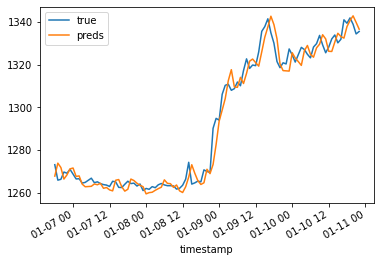

In [14]:
rescaled_data.iloc[-600:-500,:-3].plot()

<Axes: xlabel='timestamp'>

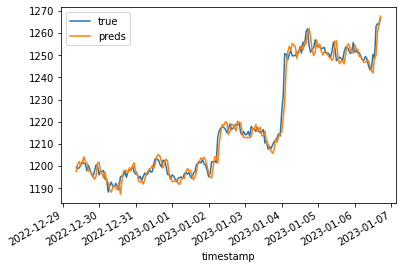

In [15]:
rescaled_data.iloc[-800:-600,:-3].plot()

In [16]:
class SimpleBacktester:
    def __init__(self, initial_cash, data, buy_threshold, sell_threshold, fee=0.001):
        self.initial_cash = initial_cash
        self.data = data
        self.cash = initial_cash
        self.asset_value = 0
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold
        self.fee = fee

    def run(self):
        portfolio = pd.DataFrame(index=self.data.index)
        portfolio['cash'] = 0
        portfolio['asset_value'] = 0
        portfolio['total_value'] = 0
        portfolio['returns'] = 0
        trade_counter = 0
        positive_trades = 0
        total_fees = 0

        for i in range(len(self.data)):
            if self.data['risk_adj_predicted_return'].iloc[i] > self.buy_threshold and self.asset_value == 0:
                # Buy as much as possible, considering fee
                amount_to_invest = self.cash * (1 - self.fee)
                fee_paid = self.cash - amount_to_invest
                total_fees += fee_paid
                self.asset_value = amount_to_invest / self.data['true'].iloc[i]
                self.cash -= amount_to_invest
                trade_counter += 1

            elif self.data['risk_adj_predicted_return'].iloc[i] < self.sell_threshold and self.asset_value > 0:
                # Sell all
                asset_sale_value = self.asset_value * self.data['true'].iloc[i]
                fee_paid = asset_sale_value * self.fee
                total_fees += fee_paid
                asset_sale_value -= fee_paid
                if asset_sale_value > self.asset_value:
                    positive_trades += 1
                self.cash += asset_sale_value
                self.asset_value = 0
                trade_counter += 1

            portfolio['cash'].iloc[i] = self.cash
            portfolio['asset_value'].iloc[i] = self.asset_value * self.data['true'].iloc[i]
            portfolio['total_value'].iloc[i] = portfolio['cash'].iloc[i] + portfolio['asset_value'].iloc[i]
            if i > 0:
                portfolio['returns'].iloc[i] = (portfolio['total_value'].iloc[i] - portfolio['total_value'].iloc[i-1]) / portfolio['total_value'].iloc[i-1]

        # calculate performance metrics
        portfolio['drawdown'] = portfolio['total_value'] / portfolio['total_value'].cummax() - 1.0
        average_drawdown = portfolio['drawdown'].mean()
        sharpe_ratio = portfolio['returns'].mean() * np.sqrt(8766) / portfolio['returns'].std()
        sortino_ratio = portfolio['returns'].mean() * np.sqrt(8766) / portfolio['returns'][portfolio['returns'] < 0].std()

        return portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees
    
def downside_deviation(series):
    # series below 0
    downside = series[series < 0]
    return np.sqrt((downside**2).mean())

# Calculate the downside deviation for a rolling window
downside_dev = rescaled_data['true_return'].rolling(window=12).apply(downside_deviation, raw=True)

rescaled_data['risk_adj_predicted_return'] = rescaled_data['predicted_return'] / downside_dev

In [ ]:
ponderer rentab par erreurs de l'algo

Average Drawdown:  -0.21631933621227525
Sharpe Ratio:  -1.135071513290734
Sortino Ratio:  -0.49767158949541546
trade_counter:  820
total fees:  1298.7399700837057
Total value: 7156.127632375123


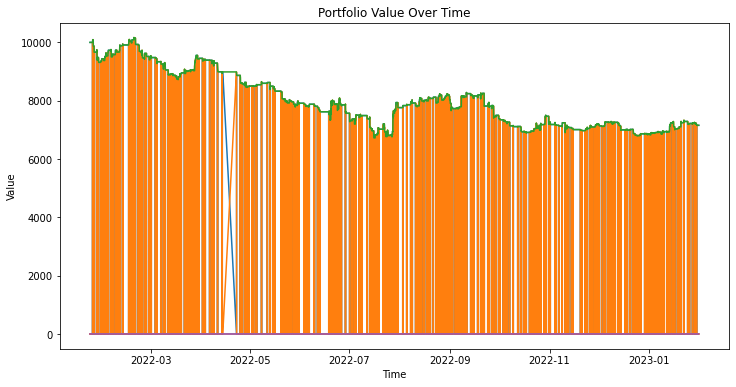

In [20]:


b,s =0.9,0
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.05701885871065834
Sharpe Ratio:  1.704561253494305
Sortino Ratio:  1.1374563641184403
trade_counter:  454
total fees:  1021.8420331955645
Total value: 15020.032064375813


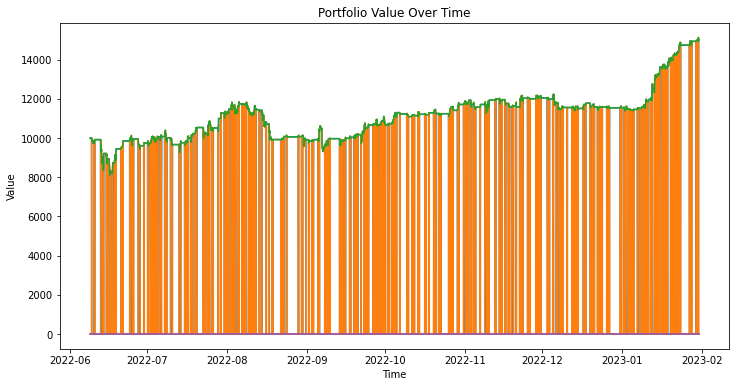

In [69]:
#bch

b,s =1.2,-.6
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.05241547737639377
Sharpe Ratio:  2.590419447091657
Sortino Ratio:  1.9621368175179164
trade_counter:  1468
total fees:  4515.543519384277
Total value: 24183.687362499884


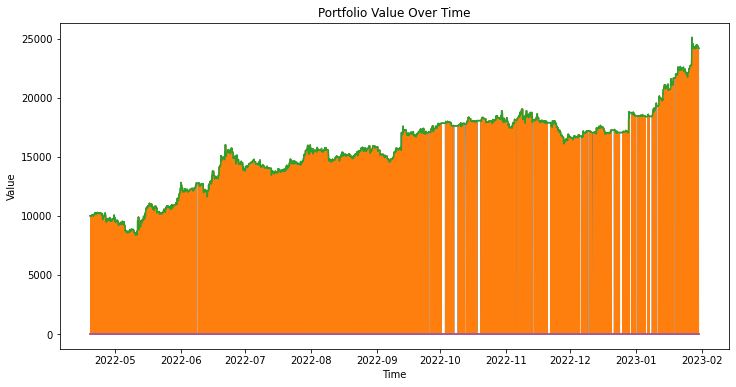

In [36]:
#HOTUSDT

b,s =.4, -.1
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.03775747888856728
Sharpe Ratio:  2.684211390978703
Sortino Ratio:  1.6470565561111512
trade_counter:  414
total fees:  1350.6248083387543
Total value: 19788.900528553204


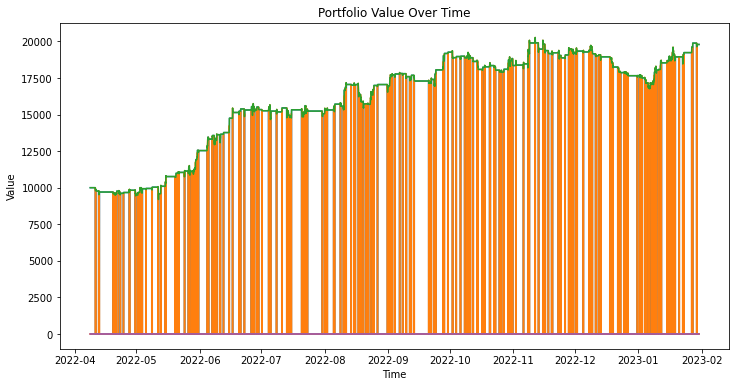

In [11]:
#linkusdt

b,s =1.15, -.4
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

<Axes: xlabel='timestamp'>

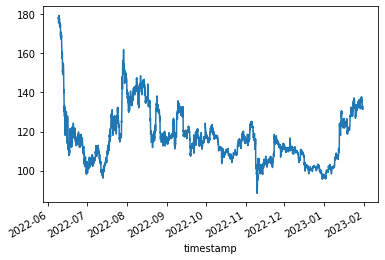

In [70]:
data_aligned['close'][data_aligned.index.isin(rescaled_data.index)].plot()

Average Drawdown:  -0.07796261807091191
Sharpe Ratio:  3.262123640301264
Sortino Ratio:  2.372738375760806
trade_counter:  994
total fees:  2944.0270264968885
Total value: 20533.56464211645


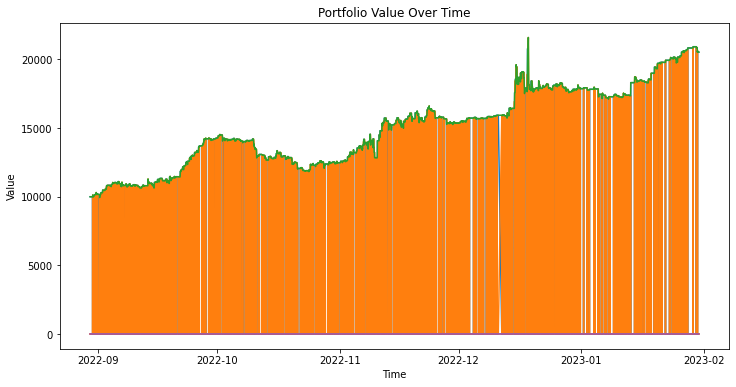

In [91]:
#PSG_ohlc_8_top2_samelr

b,s =0.45, .15
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.1044359233032394
Sharpe Ratio:  2.106185469749583
Sortino Ratio:  1.9146645089890435
trade_counter:  2381
total fees:  5910.966928435985
Total value: 18776.98029325953


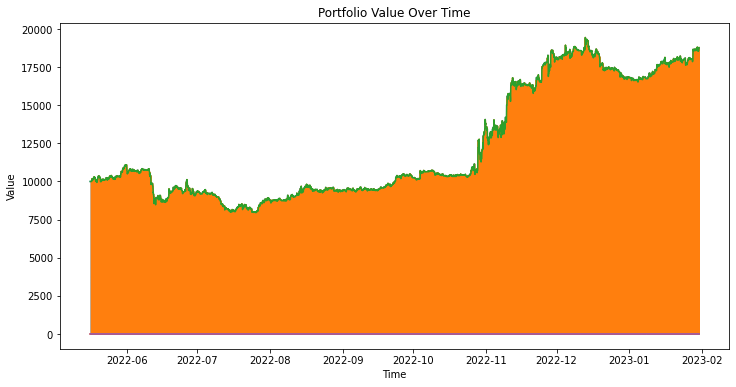

In [18]:
#DOGE

b,s =0, -0.1
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.08258641853715744
Sharpe Ratio:  2.581972120560185
Sortino Ratio:  2.2864000586243356
trade_counter:  1690
total fees:  4909.636129037809
Total value: 24168.50279024399


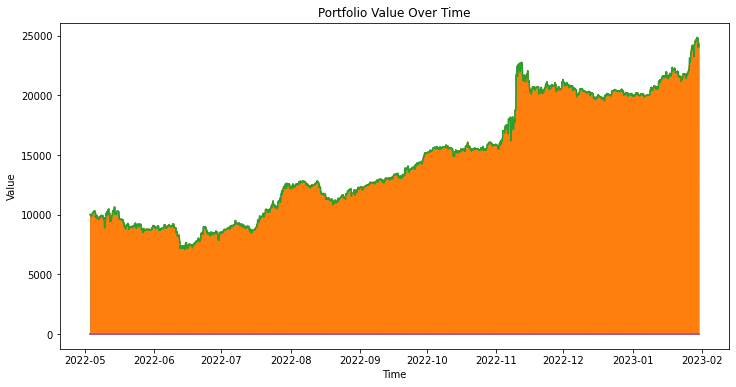

In [57]:
#MATIC

b,s =0.5, 0
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.14152037768970807
Sharpe Ratio:  1.1460222913941072
Sortino Ratio:  0.9824812238960939
trade_counter:  952
total fees:  2069.7543401634994
Total value: 13261.908769245838


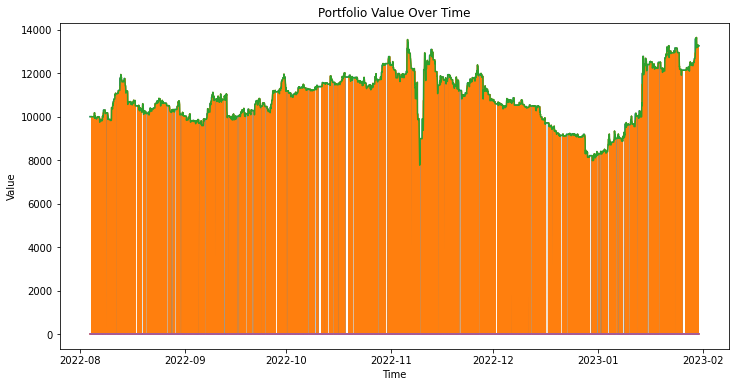

In [65]:
#SOL

b,s = 0.58, -0.48
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [ ]:
tester perf sur le train

Average Drawdown:  -0.08671935441371052
Sharpe Ratio:  0.4612205032252747
Sortino Ratio:  0.29476447834889713
trade_counter:  276
total fees:  2744.5888221288674
Total value: 10473.30199225123


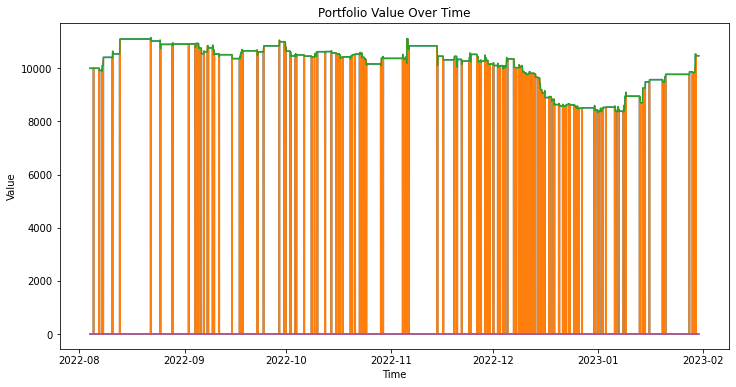

In [64]:
#☻btc
b,s = 1.6,-0.6
backtester = SimpleBacktester(10000, rescaled_data, b, s)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [ ]:
x sur la strategie passive, y sur la strategie moyenne, z sur la strategie agressive.


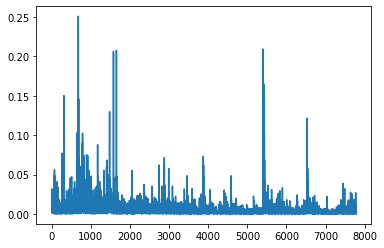

In [102]:
plt.plot(np.abs(preds.T[0][0]-true.T[0][0]))# test bruit blanc

In [52]:
fracDiff = FractionalDifferentiator()
frac_data = fracDiff.Fit(data)
frac_data = fracDiff.Transform(data).dropna()
frac_data_target = frac_data[['close']].copy().shift(-1).iloc[:-1]
frac_data_aligned = frac_data.iloc[:-1,:-150]#-150]
frac_data_aligned["target"] = frac_data_target

original_target = data[['close']].copy().shift(-1).iloc[:-1]
fracDiff.Fit(original_target)
numLags = fracDiff.numLags
lagData = original_target.head(max(numLags))
rescaled_frac_data.index = original_target.iloc[-len(preds):].index #attention
offset = len(original_target)-len(preds)
maxindex = None

normal_scale_data = pd.DataFrame()
normal_scale_data['true'] = fracDiff.InverseTransform(rescaled_frac_data['true'], lagData).iloc[fracDiff.numLags[0]:]
normal_scale_data['preds'] = fracDiff.InverseTransform(rescaled_frac_data['preds'], lagData).iloc[fracDiff.numLags[0]:]
normal_scale_data['true_return'] = normal_scale_data['true'].pct_change()
normal_scale_data['predicted_return'] = normal_scale_data['preds'] / normal_scale_data['true'].shift(1) - 1
normal_scale_data = normal_scale_data[1:]